In [1]:
import ngmix
import fitsio
import proplot as pplt
import numpy as np
import piff
import galsim
import yaml

In [2]:
%matplotlib inline

In [3]:
TNAMES = ["DES0131-3206", "DES0137-3749", "DES0221-0750", "DES0229-0416"]
BANDS = ["g", "r", "i", "z"]

with open(
    "/Users/beckermr/MEDS_DIR/des-pizza-slices-y6-test/pizza_cutter_info/"
    "%s_%s_pizza_cutter_info.yaml" % (TNAMES[0], BANDS[0])
) as fp:
    yml = yaml.safe_load(fp.read())

In [276]:
import scipy.optimize

def _get_star_stamp_pos(s, img, wgt, bbox):
    xint = int(np.floor(s.x - 1 + 0.5))
    yint = int(np.floor(s.y - 1 + 0.5))
    bbox_2 = (bbox - 1)//2

    return dict(
        img=img[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1].copy(),
        wgt=wgt[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1].copy(),
        xstart=xint-bbox_2,
        ystart=yint-bbox_2,
        dim=bbox,
        x=s.x - 1,
        y=s.y - 1,
    )


def get_star_obs(piff_mod, s, img, wgt, piff_prop, star_dim):

    if piff_prop:
        kwargs = {
            piff_prop: s.data.properties[piff_prop]
        }
    else:
        kwargs = {}
    sres = _get_star_stamp_pos(s, img, wgt, star_dim)
    sres.update(**kwargs)

    xv = sres["x"]+1
    yv = sres["y"]+1
    wcs = list(piff_mod.wcs.values())[0].local(
        image_pos=galsim.PositionD(x=xv, y=yv)
    ).jacobian()
    img = galsim.ImageD(sres["dim"], sres["dim"], wcs=wcs)
    cen = (
        sres["x"] - sres["xstart"] + 1,
        sres["y"] - sres["ystart"] + 1,
    )
    _img = sres.pop("img")
    _wgt = sres.pop("wgt")
    nrm = _img.sum()
    nrm2 = nrm*nrm
    _img /= nrm
    _wgt *= nrm2
    
    star_obs = ngmix.Observation(
        image=_img,
        weight=_wgt,
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    sres["local_wcs"] = wcs
    star_obs.update_meta_data(sres)
    
    if star_obs.get_s2n() > 100:
        nse = np.sqrt(np.sum(star_obs.image**2)) / 100
        star_obs.weight = np.ones_like(star_obs.weight) / nse**2

    return star_obs


def _draw_galsim_model(*, mod, offset_x, offset_y, local_wcs, dim, method):
    return mod.drawImage(
        nx=dim, ny=dim, 
        wcs=local_wcs, 
        offset=galsim.PositionD(x=offset_x, y=offset_y),
        method=method,
    ).array


def _predict_star(
    *, dilation_params, g1_params, g2_params, 
    star_colxy, offset_x, offset_y, local_wcs,
    star_dim, model_dim, model_scale, piff_model, x, y, col,
):
    dilation = min(max(1.0 + np.dot(dilation_params, star_colxy), 0.95), 1.05)
    g1 = np.dot(g1_params, star_colxy)
    g2 = np.dot(g2_params, star_colxy)
    mod, method = piff_model.get_profile(
        x=x, 
        y=y,  
        chipnum=list(piff_mod.wcs.keys())[0],
        GI_COLOR=col,
    )
    mod = mod.dilate(dilation).shear(eta1=g1, eta2=g2)
    img = _draw_galsim_model(
        mod=mod, 
        offset_x=offset_x,
        offset_y=offset_y, 
        local_wcs=local_wcs, 
        dim=star_dim,
        method=method,
    )
        
    return img


def _build_star_xy_colxy(*, x, y, col, colcen, colscale, xcen=1024, ycen=2048, xyscale=2048):
    xs = (x-xcen)/xyscale
    ys = (y-ycen)/xyscale
    cols = (col-colcen)/colscale
    
    return (
        np.array([1, xs, xs, xs*ys]), 
        np.array([
            1,
            cols, 
            xs*cols, 
            ys*cols,
            xs*xs*cols,
            xs*ys*cols,
            ys*ys*cols,
            cols*cols,
#             xs*cols*cols, 
#             ys*cols*cols,
        ])
    )


def _init_model_params(*, model_dim, rng, stars, model_scale, init_scale, param_dim):
    # dilation + 2 shears + n_stars * 3 (offset_x, offset_y, flux)
    n_stars = len(stars)
    tot = 3*param_dim
    nse = rng.normal(size=tot, scale=init_scale)
    return nse


def _extract_model_params(params, fit_data):
    nxy = 0
    nd = fit_data["param_dim"]
    dilation_params = params[nxy:nxy+nd]
    g1_params = params[nxy+nd:nxy+2*nd]
    g2_params = params[nxy+2*nd:nxy+3*nd]
    
    return nxy, dilation_params, g1_params, g2_params
    

def _compute_model_resid(params, fit_data):
    nxy, dilation_params, g1_params, g2_params = _extract_model_params(
        params, fit_data
    )
    star_params = np.zeros(len(fit_data["stars"])*2)  # params[nxy+12:]
    
    n_resids_per_star = fit_data["star_dim"]**2 + 2
    n_resids = fit_data["n_stars"] * n_resids_per_star
    resids = np.zeros(n_resids)
    rloc = 0
    for sind, sobs in enumerate(fit_data["stars"]):
        xy, colxy = _build_star_xy_colxy(
            x=sobs.meta["x"] + star_params[2*sind+0], 
            y=sobs.meta["y"] + star_params[2*sind+1], 
            col=sobs.meta["col"], 
            colcen=fit_data["colcen"], 
            colscale=fit_data["colscale"],
        )
        
        simg = _predict_star(
            dilation_params=dilation_params, 
            g1_params=g1_params, 
            g2_params=g2_params, 
            star_colxy=colxy, 
            offset_x=star_params[2*sind+0] + sobs.meta["cen_offset_x"], 
            offset_y=star_params[2*sind+1] + sobs.meta["cen_offset_y"], 
            local_wcs=sobs.meta["local_wcs"],
            star_dim=fit_data["star_dim"], 
            model_dim=fit_data["model_dim"], 
            model_scale=fit_data["model_scale"],
            piff_model=fit_data["piff_model"],
            x=sobs.meta["x"] + star_params[2*sind+0]+1, 
            y=sobs.meta["y"] + star_params[2*sind+1]+1,   
            col=fit_data["colcen"] if fit_data["use_colcen"] else sobs.meta["col"],
        )
        simg = simg.ravel()
        resids[rloc:rloc+simg.shape[0]] = (sobs.image.ravel() - simg) * sobs.meta["sqrt_wgt_ravel"]
#         resids[rloc+simg.shape[0]+0] = star_params[2*sind+0]/fit_data["offset_width"]
#         resids[rloc+simg.shape[0]+1] = star_params[2*sind+1]/fit_data["offset_width"]
        rloc += n_resids_per_star
        
    if fit_data["itr"] % 10 == 0 and fit_data["verbose"]:
        n_data = len(fit_data["stars"]) * fit_data["star_dim"]**2
        print("itr:", fit_data["itr"])
        print("    chi2/dof:", np.sum(resids**2)/(n_data - len(params)))
        print("    params:", params.min(), params.max())
        print("    resids:", resids.min(), resids.max())
        if "last_params" in fit_data:
            print("    diff params:", np.max(np.abs(fit_data["last_params"] - params)))
    fit_data["itr"] = fit_data["itr"] + 1
    fit_data["last_params"] = params.copy()
    
        
    return resids
    

def _build_fit_data(
    *, star_dim, model_dim, model_scale, offset_width, 
    stars, colname, colcen, colscale, init_scale, piff_model,
):
    fit_data = dict(
        star_dim=star_dim,
        model_dim=model_dim,
        offset_width=offset_width,
        stars=stars,
        colcen=colcen,
        colscale=colscale,
        model_scale=model_scale,
        n_stars=len(stars),
        colname=colname,
        init_scale=init_scale,
        piff_model=piff_model,
        use_colcen=True,
        itr=0,
        verbose=False,
    )
    for star in stars:
        star.meta["sqrt_wgt_ravel"] = np.sqrt(np.ravel(star.weight))
        star.meta["cen_offset_x"] = star.meta["x"] - np.floor(star.meta["x"] + 0.5)
        star.meta["cen_offset_y"] = star.meta["y"] - np.floor(star.meta["y"] + 0.5)
        star.meta["col"] = star.meta[colname]
    fit_data["stars"] = stars
    
    _, dd = _build_star_xy_colxy(
        x=10, y=10, col=1, colcen=0, colscale=1
    )
    fit_data["param_dim"] = dd.shape[0]
    
    images = np.array([
        galsim.InterpolatedImage(
            galsim.ImageD(s.image), 
            wcs=s.meta["local_wcs"], 
            offset=(s.meta["cen_offset_x"], s.meta["cen_offset_y"]),
            flux=1,
        ).drawImage(nx=model_dim, ny=model_dim, scale=model_scale, method="no_pixel").array.ravel()
        for s in stars
    ])
    
    coeffs = np.array([
        _build_star_xy_colxy(
            x=s.meta["x"], y=s.meta["y"], col=s.meta["col"], 
            colcen=colcen, colscale=colscale,
        )[0]
        for s in stars
    ])
    A = np.linalg.lstsq(coeffs, images, rcond=None)[0]
    fit_data["poly_guess"] = A.T.ravel()
    
    return fit_data


class MattsColorModel(object):
    """TODO
    """
    def __init__(
        self, 
        *,
        piff_model, image, weight, 
        colname, colcen, colscale,
        init_scale=0.01,
        star_dim=17, model_dim=17, offset_width=0.5, 
        model_scale=0.3,
        seed=None,
    ):
        self.image = image
        self.weight = weight
        self.piff = piff_model
        stars = [
            get_star_obs(self.piff, s, self.image, self.weight, colname, star_dim)
            for s in self.piff.stars
        ]

        self.fit_data = _build_fit_data(
            star_dim=star_dim, 
            model_dim=model_dim, 
            offset_width=offset_width,
            stars=stars, 
            colname=colname, 
            colcen=colcen, 
            colscale=colscale,
            model_scale=model_scale,
            init_scale=init_scale,
            piff_model=piff_model,
        )
        self.stars = self.fit_data["stars"]

        self.rng = np.random.RandomState(seed=seed)
        self.wcs = {0: None}
        
    def fit(self, **kwargs):
        try:
            x0 = self.get_init_params()
            self.fit_data["itr"] = 0
            self.fit_data["verbose"] = kwargs.get("verbose", False)
            if "last_params" in self.fit_data:
                self.fit_data.pop("last_params")
            self.fit_res = scipy.optimize.least_squares(
                _compute_model_resid, 
                x0, 
                args=(self.fit_data,), 
                **kwargs,
            )
        finally:
            self.fit_data["verbose"] = False

    def chi2(self, params=None, use_piff_color_dep=False):
        if params is None:
            if not hasattr(self, "fit_res"):
                raise RuntimeError("WTF")        
            params = self.fit_res.x
        
        oldval = self.fit_data["use_colcen"]
        try:
            self.fit_data["use_colcen"] = not use_piff_color_dep
            chi = _compute_model_resid(params, self.fit_data)
        finally:
            self.fit_data["use_colcen"] = oldval
        
        return np.sum(chi**2)
    
    def get_init_params(self, init_scale=None):
        return _init_model_params(
                model_dim=self.fit_data["model_dim"], 
                rng=self.rng, 
                stars=self.fit_data["stars"], 
                model_scale=self.fit_data["model_scale"],
                init_scale=init_scale or self.fit_data["init_scale"],
                param_dim=self.fit_data["param_dim"],
            )
    
    def draw(self, x, y, offset=None, params=None, **kwargs):
        if self.fit_data["colname"] in kwargs:
            col = kwargs[self.fit_data["colname"]]
        else:
            col = self.fit_data["colcen"]
        
        if params is None:
            if not hasattr(self, "fit_res"):
                raise RuntimeError("WTF")        
            params = self.fit_res.x
        
        x -= 1
        y -= 1
        wcs = list(self.piff.wcs.values())[0].local(
            image_pos=galsim.PositionD(x=x+1, y=y+1)
        ).jacobian()

        xy, colxy = _build_star_xy_colxy(
            x=x, y=y, col=col, colcen=self.fit_data["colcen"], colscale=self.fit_data["colscale"]
        )
        
        _, dilation_params, g1_params, g2_params = _extract_model_params(
            params, self.fit_data
        )
        
        if offset is None:
            offset = (
                x - np.floor(x+0.5),
                y - np.floor(y+0.5),
            )
        
        return galsim.ImageD(
            _predict_star(
                dilation_params=dilation_params, 
                g1_params=g1_params, 
                g2_params=g2_params, 
                star_colxy=colxy, 
                offset_x=offset[0], 
                offset_y=offset[1], 
                local_wcs=wcs,
                star_dim=self.fit_data["star_dim"], 
                model_dim=self.fit_data["model_dim"], 
                model_scale=self.fit_data["model_scale"],
                piff_model=self.fit_data["piff_model"],
                x=x+1,
                y=y+1,
                col=self.fit_data["colcen"],
            ),
            wcs=wcs,
        )

In [277]:
sind = 15

src = yml["src_info"][sind]
piff_mod = piff.read(src["piff_path"])

img = (
    fitsio.read(src["image_path"], ext=src["image_ext"])
    - fitsio.read(src["bkg_path"], ext=src["bkg_ext"])
)
wgt = fitsio.read(src["weight_path"], ext=src["weight_ext"])

In [278]:
mmod = MattsColorModel(
    piff_model=piff_mod, 
    image=img, 
    weight=wgt, 
    colname="GI_COLOR", 
    colcen=1.6, 
    colscale=1.5,
    init_scale=0.01,
)

In [279]:
p = mmod.get_init_params()
p[:] = 0
chi2 = mmod.chi2(params=p, use_piff_color_dep=True)
print("piff chi2/dof:", chi2/(mmod.fit_data["star_dim"]**2 * len(mmod.fit_data["stars"]) - len(p)))

piff chi2/dof: 1.318531626192846


In [280]:
mmod.fit(method="lm", verbose=2, diff_step=1e-3, xtol=1e-4, ftol=1e-4)

itr: 0
    chi2/dof: 2.3718360023398803
    params: -0.016369366053318443 0.022197929290286234
    resids: -47.13754093618209 18.257117297832302
itr: 10
    chi2/dof: 2.371781298352926
    params: -0.016369366053318443 0.022197929290286234
    resids: -47.13559071575198 18.256872578519673
    diff params: 1.333693845574982e-05
itr: 20
    chi2/dof: 2.3718377388852363
    params: -0.016369366053318443 0.022197929290286234
    resids: -47.13763796207414 18.256981478613792
    diff params: 1.4754003046190539e-05
itr: 30
    chi2/dof: 2.236520235852596
    params: -0.19373887377768167 0.5954482773224434
    resids: -40.51825993423143 17.349590410102603
    diff params: 0.00012072588832676145
itr: 40
    chi2/dof: 2.236754369000516
    params: -0.19373887377768167 0.5954482773224434
    resids: -40.52648772987689 17.35184488677021
    diff params: 0.00039907208520106874
itr: 50
    chi2/dof: 2.2367354277824267
    params: -0.19373887377768167 0.5954482773224434
    resids: -40.5275453121001

In [281]:
mmod.fit_res.x

array([ 2.69853559e-02,  1.71302923e-02,  3.87208579e-02,  2.85077086e-02,
       -3.58361260e-01,  9.46118753e-02,  5.61621414e-02, -5.08333526e-02,
        2.45556622e-04,  1.84800328e-03, -1.34949326e-02, -2.06924931e-02,
       -6.74158073e-02, -3.68898260e-02, -3.90859636e-03,  1.37862810e-02,
        1.94619282e-03, -7.34451274e-03, -5.34890578e-03,  9.50812402e-03,
        5.92809376e-02, -6.68433962e-02, -1.55775794e-02, -1.32329733e-02])

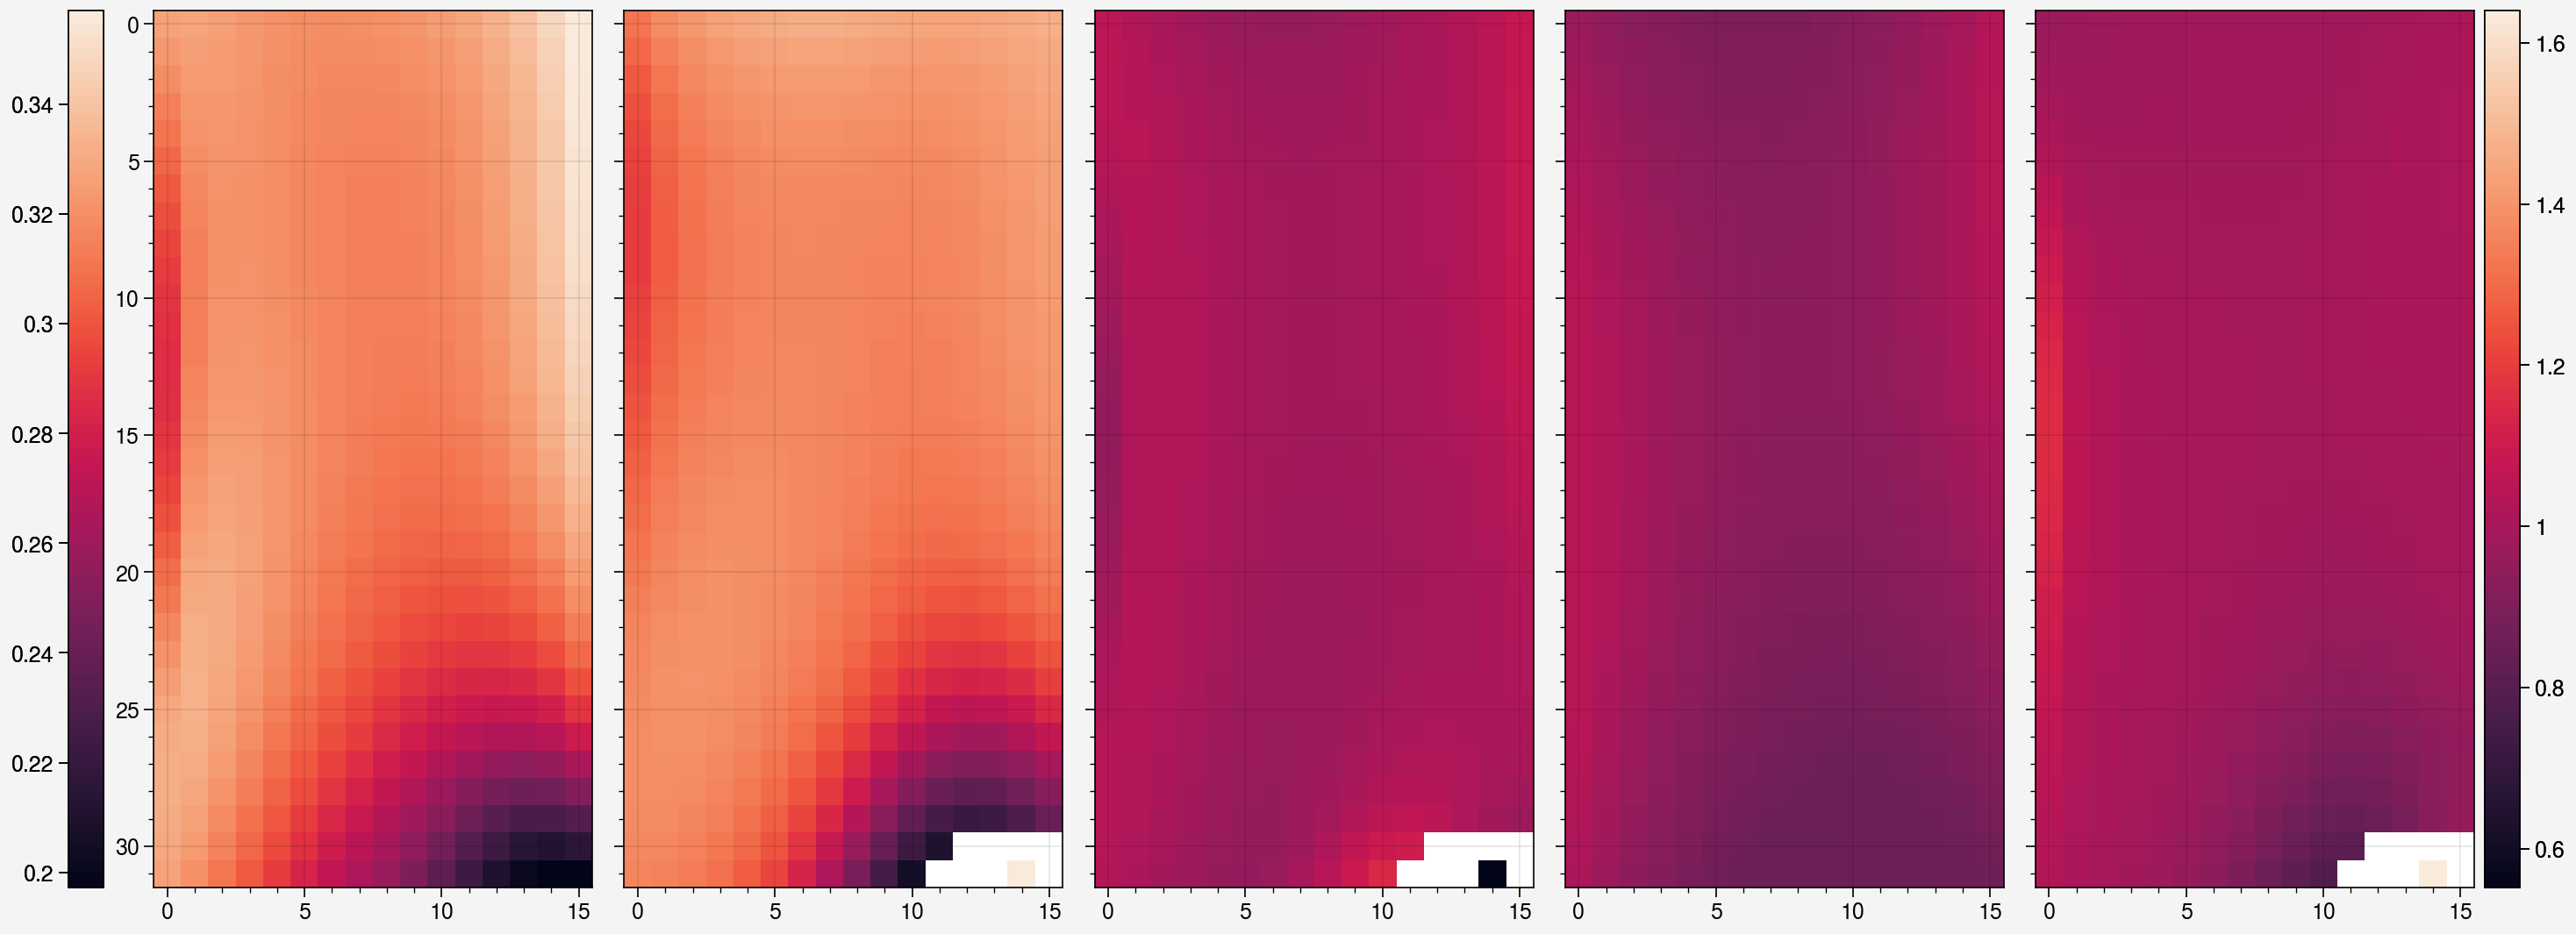

In [298]:
from des_y6utils.piff import measure_t_grid_for_piff_model

res_me = measure_t_grid_for_piff_model(mmod, {"GI_COLOR": 0.61})
res_piff = measure_t_grid_for_piff_model(piff_mod, {"GI_COLOR": 0.61})


res_me_s = measure_t_grid_for_piff_model(mmod, {"GI_COLOR": 1.61})
res_piff_s = measure_t_grid_for_piff_model(piff_mod, {"GI_COLOR": 1.61})

vmin = min(np.nanmin(res_me), np.nanmin(res_piff))
vmax = min(np.nanmax(res_me), np.nanmax(res_piff))

fig, axs = pplt.subplots(ncols=5)
h = axs[0].imshow(res_me, cmap="rocket", vmin=vmin, vmax=vmax)
axs[0].colorbar(h, loc='l')
axs[1].imshow(res_piff, cmap="rocket", vmin=vmin, vmax=vmax)

vmin = np.nanmin([res_me/res_piff, res_me/res_me_s, res_piff/res_piff_s])
vmax = np.nanmax([res_me/res_piff, res_me/res_me_s, res_piff/res_piff_s])

axs[2].imshow(res_me/res_piff, cmap="rocket", vmin=vmin, vmax=vmax)
axs[3].imshow(res_me/res_me_s, cmap="rocket", vmin=vmin, vmax=vmax)
h = axs[4].imshow(res_piff/res_piff_s, cmap="rocket", vmin=vmin, vmax=vmax)
axs[4].colorbar(h, loc="r")

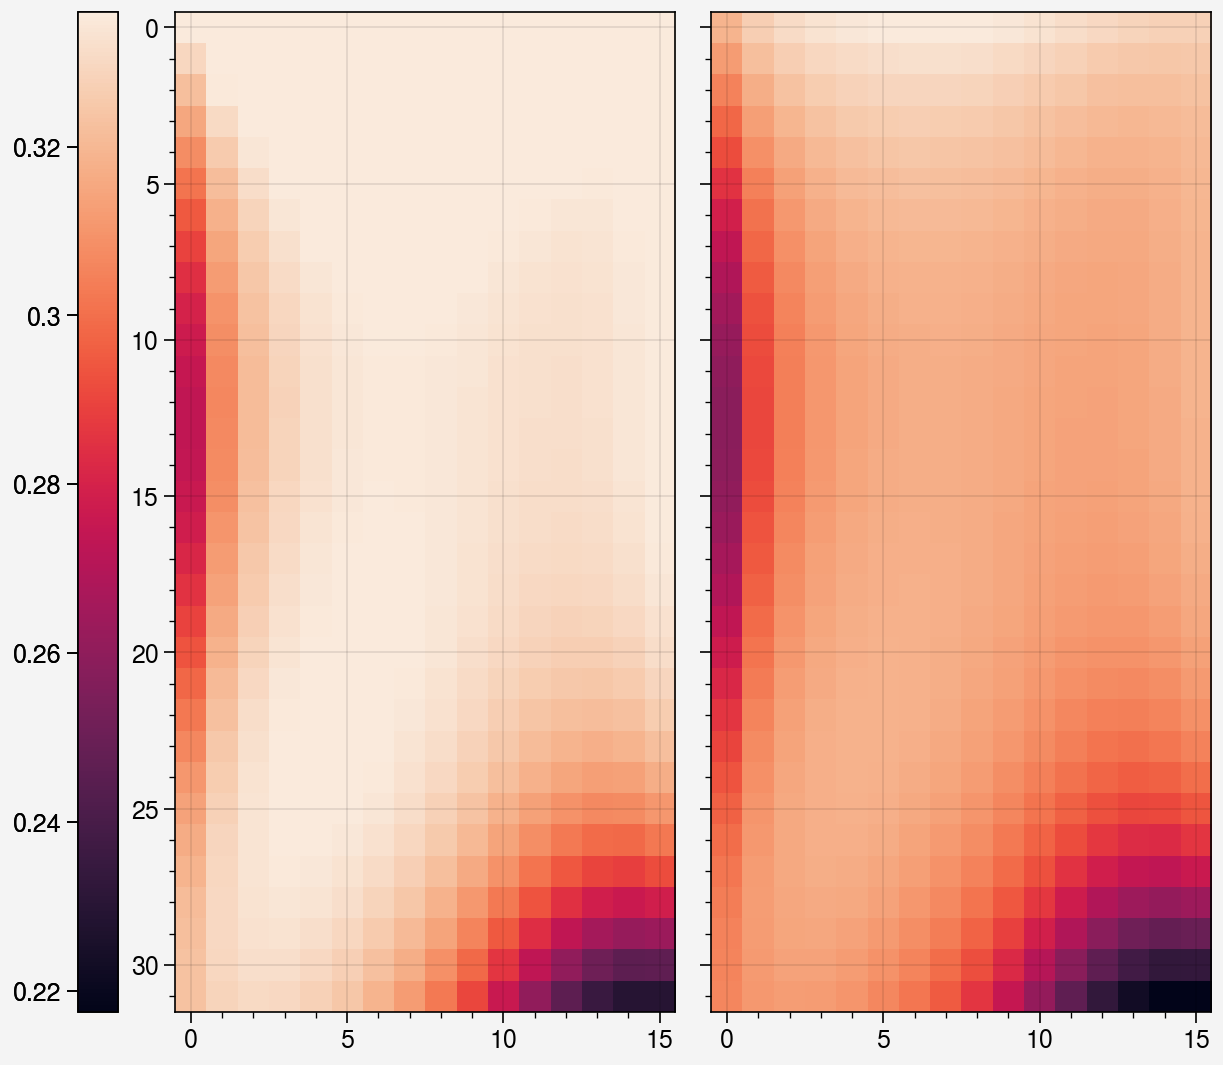

In [286]:
res_me = measure_t_grid_for_piff_model(mmod, {"GI_COLOR": 1.61})
res_piff = measure_t_grid_for_piff_model(piff_mod, {"GI_COLOR": 1.61})

vmin = min(np.nanmin(res_me), np.nanmin(res_piff))
vmax = min(np.nanmax(res_me), np.nanmax(res_piff))

fig, axs = pplt.subplots(ncols=2)
h = axs[0].imshow(res_me, cmap="rocket", vmin=vmin, vmax=vmax)
axs[0].colorbar(h, loc='l')
axs[1].imshow(res_piff, cmap="rocket", vmin=vmin, vmax=vmax)

sums piff|me|img: 0.9908604983160619 0.9882489641919392 0.9999999987304591
piff chi2/dof: 0.8061321390041394
me   chi2/dof: 1.0269148507605792
color|dilation|g1|g2: 0.6087742005081724 1.0042476954219666 0.0022588938598898135 0.011871019956896045


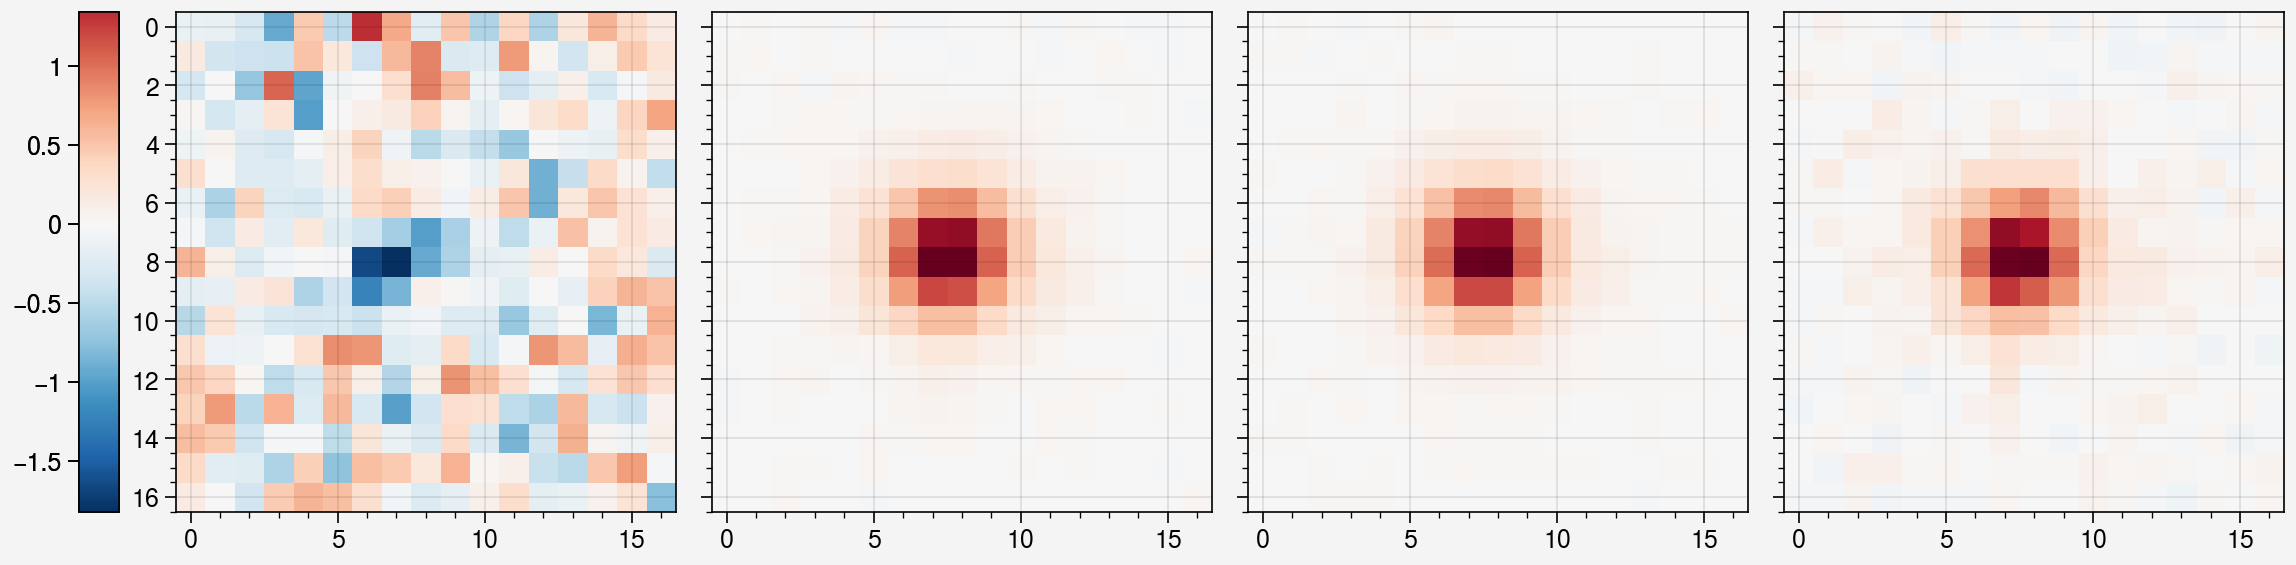

In [289]:
i = 10
_img = mmod.draw(x=mmod.stars[i].meta["x"], y=mmod.stars[i].meta["y"], GI_COLOR=mmod.stars[i].meta["col"])

piff_img = galsim.ImageD(
    mmod.fit_data["star_dim"], 
    mmod.fit_data["star_dim"], 
    wcs=mmod.stars[i].meta["local_wcs"],
)
dx = mmod.stars[i].meta["x"] - np.floor(mmod.stars[i].meta["x"] + 0.5) + (mmod.fit_data["star_dim"] -1)/2
dy = mmod.stars[i].meta["y"] - np.floor(mmod.stars[i].meta["y"] + 0.5) + (mmod.fit_data["star_dim"] -1)/2
piff_img = piff_mod.draw(
    x=mmod.stars[i].meta["x"]+1, 
    y=mmod.stars[i].meta["y"]+1, 
    GI_COLOR=mmod.stars[i].meta["col"], 
    chipnum=list(piff_mod.wcs.keys())[0],
    center=(dx+1, dy+1),
    image=piff_img,
)
print(
    "sums piff|me|img:", 
    np.sum(piff_img.array), 
    np.sum(_img.array), 
    np.sum(mmod.stars[i].image)
)
fig, axs = pplt.subplots(nrows=1, ncols=4)

swgt = np.sqrt(mmod.stars[i].weight)
piff_img = piff_img.array
h0 = axs[0].imshow((_img.array - piff_img) * swgt)
axs[0].colorbar(h0, loc='l')

axs[1].imshow(piff_img)
axs[2].imshow(_img.array)
axs[3].imshow(mmod.stars[i].image)

dof = mmod.fit_data["star_dim"]**2
print(
    "piff chi2/dof:", 
    np.sum(((mmod.stars[i].image - piff_img) * np.sqrt(mmod.stars[i].weight))**2)/dof
)
print(
    "me   chi2/dof:",
    np.sum(((mmod.stars[i].image - _img.array/np.sum(_img.array)) * np.sqrt(mmod.stars[i].weight))**2)/dof
)

_, star_colxy = _build_star_xy_colxy(
    x=mmod.stars[i].meta["x"], 
    y=mmod.stars[i].meta["y"], 
    col=mmod.stars[i].meta["col"], 
    colcen=mmod.fit_data["colcen"], colscale=mmod.fit_data["colscale"]
)

_, dilation_params, g1_params, g2_params = _extract_model_params(
    mmod.fit_res.x, mmod.fit_data
)


dilation = min(max(1.0 + np.dot(dilation_params, star_colxy), 0.95), 1.05)
g1 = np.dot(g1_params, star_colxy)
g2 = np.dot(g2_params, star_colxy)
print("color|dilation|g1|g2:", mmod.stars[i].meta["col"], dilation, g1, g2)

In [176]:
piff_mod.chisq / piff_mod.dof

0.3533296251660292

In [ ]:
%debug

In [ ]:
thresh = 10
t_arr = measure_t_grid_for_piff_model(piff_mod, {"GI_COLOR": 0.61})
data = measure_star_t_for_piff_model(piff_mod, img, wgt, piff_prop="GI_COLOR")
ts_arr = map_star_t_to_grid(data)

res_g = make_good_regions_for_piff_model_gal_grid(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=11, verbose=False)
res_sg = make_good_regions_for_piff_model_star_and_gal_grid(
    piff_mod, img, wgt, piff_kwargs={"GI_COLOR": 0.61}, seed=11, verbose=False,
    flag_bad_thresh=thresh, any_bad_thresh=thresh,
)

In [ ]:
vmin = min(np.nanmin(ts_arr), np.nanmin(t_arr))
vmax = max(np.nanmax(ts_arr), np.nanmax(t_arr))

fig, axs = pplt.subplots(ncols=3, share=0)
h0 = axs[0].imshow(ts_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[0].grid(False)
axs[0].set_title("stars on grid w/ 2d poly")
axs[0].colorbar(h0, loc='l')

axs[1].imshow(t_arr, vmin=vmin, vmax=vmax, cmap="rocket")
axs[1].grid(False)
axs[1].set_title("grid of shapes at gal color")

b = res_g["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="red")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="red")

b = res_sg["bbox"]
axs[1].plot([b["xmin"]/128, b["xmin"]/128], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmax"]/128 - 1, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymax"]/128 - 1], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymin"]/128, b["ymin"]/128], color="blue")
axs[1].plot([b["xmin"]/128, b["xmax"]/128 - 1], [b["ymax"]/128 - 1, b["ymax"]/128 - 1], color="blue")

harr = (t_arr-ts_arr).ravel()
std5 = nanmad(harr) * thresh
h = axs[2].hist(harr, bins=50)
axs[2].vlines([-std5, np.nanmedian(harr)+std5], 0, np.max(h[0]), color="k")
axs[2].set_xlabel("gal T - star T")
ax = axs[0]

In [ ]:
import ngmix

def get_star_stamp_pos(s, img, wgt):
    xint = int(np.floor(s.x - 1 + 0.5))
    yint = int(np.floor(s.y - 1 + 0.5))
    bbox = 17
    bbox_2 = (bbox - 1)//2
    
    return dict(
        img=img[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        wgt=wgt[yint-bbox_2: yint+bbox_2+1, xint-bbox_2: xint+bbox_2+1],
        xstart=xint-bbox_2, 
        ystart=yint-bbox_2,
        dim=bbox,
        x=s.x - 1,
        y=s.y - 1,
    )

def get_star_piff_obs(piff_mod, s, img, wgt):
    
    sres = get_star_stamp_pos(s, img, wgt)
    
    xv = sres["x"]+1
    yv = sres["y"]+1
    wcs = list(piff_mod.wcs.values())[0].local(
        image_pos=galsim.PositionD(x=xv, y=yv)
    ).jacobian()
    img = galsim.ImageD(sres["dim"], sres["dim"], wcs=wcs)
    cen = (
        sres["x"] - sres["xstart"] + 1,
        sres["y"] - sres["ystart"] + 1,
    )
    img = piff_mod.draw(
        x=xv, y=yv, chipnum=list(piff_mod.wcs.keys())[0],
        GI_COLOR=s.data.properties["GI_COLOR"],
        image=img, center=cen,
    )
    model_obs = ngmix.Observation(
        image=img.array,
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    star_obs = ngmix.Observation(
        image=sres["img"],
        weight=sres["wgt"],
        jacobian=ngmix.Jacobian(
            y=cen[1]-1,
            x=cen[0]-1,
            wcs=wcs,
        )
    )
    return model_obs, star_obs, sres

In [ ]:

x = []
y = []
t = []

for s in piff_mod.stars:

    mobs, sobs, sres = get_star_piff_obs(piff_mod, s, img, wgt)
    
    res = ngmix.admom.AdmomFitter(
        rng=np.random.RandomState(seed=10)
    ).go(mobs, ngmix.moments.fwhm_to_T(1))
    t.append(res["T"])
    x.append(sres["x"])
    y.append(sres["y"])
    

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

degree = 2
polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
polyreg.fit(np.array([x, y]).T, np.array(t))

In [ ]:
y, x = np.mgrid[0:4096:128, 0:2048:128] + 64
tg = polyreg.predict(np.array([x.ravel(), y.ravel()]).T)

In [ ]:
tg = tg.reshape(x.shape)

In [ ]:
fig, axs = pplt.subplots(ncols=2)
axs[0].imshow(tg)
axs[1].imshow(res["t_arr"])

In [ ]:
def _nanmad(x, axis=None):
    """
    median absolute deviation - scaled like a standard deviation

        mad = 1.4826*median(|x-median(x)|)

    Parameters
    ----------
    x: array-like
        array to take MAD of
    axis : {int, sequence of int, None}, optional
        `axis` keyword for

    Returns
    -------
    mad: float
        MAD of array x
    """
    return 1.4826*np.nanmedian(np.abs(x - np.nanmedian(x, axis=axis)), axis=axis)


In [ ]:
print(_nanmad(t), _nanmad(tg))

In [ ]:
from des_y6utils.piff import make_good_regions_for_piff_model

In [ ]:
res = make_good_regions_for_piff_model(piff_mod, piff_kwargs={"GI_COLOR": 0.61}, seed=10, verbose=False)

In [ ]:
res["t_std"]

In [ ]:
fig, axs = pplt.subplots()

axs.hist((res["t_arr"] - tg).ravel(), bins=50)

In [ ]:
np.std((res["t_arr"] - tg).ravel()) * 5

In [ ]:
np.max(np.abs(np.max(t) - np.median(t)))

In [ ]:
_nanmad(t)

In [ ]:
img = np.ones((17, 17))* 5
print(img.sum())
gs = galsim.InterpolatedImage(galsim.ImageD(img), scale=0.3, x_interpolant="lanczos3", normalization="flux")

print(gs.drawImage(nx=27, ny=27, scale=0.263, method="no_pixel").array.sum())